In [168]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re
import multiprocessing
import gc

cores = multiprocessing.cpu_count() - 1 # we need to have at least one core for system operating

In [169]:
def parallelize_dataframe(df, func, cores):
    df_split = np.array_split(df, cores)
    pool = multiprocessing.Pool(cores)
    
    df = pd.concat(pool.map(func, df_split))
    
    pool.close()
    pool.join()
    
    return df

In [170]:
df_train = pd.read_csv('data/train.tsv', sep='\t')

In [171]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


Data set is quite big so lets try to compress it and to save some memory.

In [172]:
"""
Initial idea of memory optimization belongs to https://www.kaggle.com/jeru666
"""
def change_datatype_int(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
            
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)            

In [173]:
change_datatype_int(df_train)
change_datatype_float(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int32
name                 1482535 non-null object
item_condition_id    1482535 non-null int8
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float32
shipping             1482535 non-null int8
item_description     1482531 non-null object
dtypes: float32(1), int32(1), int8(2), object(4)
memory usage: 59.4+ MB


Size was decreased from 90Mb to 60Mb. Not bad.

In [174]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [175]:
df_train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

Despite the fact we have official default value for missed item description for 4 products it was missed. Lets make them correct.

In [176]:
df_train['item_description'].fillna('No description yet', inplace=True)

Category name has 6327 empty values. It is 0.4% from whole number of values in dataset. Reason for this can be mistake of user/operator or ultra-exotic product that can't be put in any existing category. Lets check these uncategorizes products

In [177]:
df_train[df_train['category_name'].isnull()].head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,NaN,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,NaN,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,Michael Kors,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."


Products like Acer Laptop and some books are quite easy to catogorize so I'll assume it was mistake of operator. Lets fix it by creating category mistake boolean feature and replacing empty category name with 'Other/Other/Other'

In [178]:
df_train['category_mistake'] = np.where(df_train['category_name'].isnull(), 1, 0)
df_train['brand_mistake'] = np.where(df_train['brand_name'].isnull(), 1, 0)
df_train['category_name'].fillna('Other/Other/Other', inplace=True)

Half of products have no brand name value. Lets check some of them.

In [179]:
df_train[df_train['brand_name'].isnull()].head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_mistake,brand_mistake
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,0,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,0,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,0,1
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",0,1
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...,0,1


First of all, there users have information about brands. For example, for index 103 name is 'kids adidas' so brand is obvious. Probably it is systematic error due to wrong and low quality UX/UI and users can't find good way to provide information they have. Probably new/edit form should be reorganized but it is outside of scope of current research.

In [180]:
brands = df_train['brand_name'].value_counts().to_frame().reset_index()
brands.columns = ['brand', 'count']

In [181]:
brands.sum()

brand    PINKNikeVictoria's SecretLuLaRoeAppleFOREVER 2...
count                                               849853
dtype: object

In [182]:
brands[brands['count'] > 100].sum()

brand    PINKNikeVictoria's SecretLuLaRoeAppleFOREVER 2...
count                                               802707
dtype: object

In [183]:
brands[brands['count'] > 100].count()

brand    566
count    566
dtype: int64

So products with 566 brands that were used more than 100 times cover ~95% of all brands used in dataset. Lets assume that it is more or less complete list of brands. Lets create low case list of these brands and try to find mentiones of these brands in product titles and descriptions.

In [184]:
brand_list = brands[brands['count'] > 100]['brand'].tolist()
brand_list = [b.replace('|', '\|') for b in brand_list] # 'A|X Armani Exchange' => 'A\|X Armani Exchange' because '|' is special character in regular expressions
r = re.compile(r'\b({0})\b'.format("|".join(brand_list)), flags=re.IGNORECASE) # regular expression will contain '(Adidas|Reebok|Nike)' type of template with 566 brands inside

In [185]:
def process_brand(row):
    current_brand_value = row['brand_name']
    
    if current_brand_value != current_brand_value: # if it is NaN
        current_description = row['item_description'].lower()
        current_name = row['name'].lower()
        
        match = r.search(current_name)
        if match:
            return match[0].lower()
            
        match = r.search(current_description)
        if match:
            return match[0].lower()
        
        return np.NaN
    else:
        return current_brand_value.lower()

def process_brand_multicore(df):
    df['brand_name'] = df.apply(lambda row: process_brand(row), axis=1)
    
    return df

df_train = parallelize_dataframe(df_train, process_brand_multicore, cores)

In [186]:
df_train['brand_was_discovered'] = np.where(((~df_train['brand_name'].isnull()) & (df_train['brand_mistake'] == 1)), 1, 0)
df_train['brand_name'].fillna('missing', inplace=True)

In [187]:
category_mean_price = df_train.groupby('category_name')['price'].mean().to_frame().reset_index()
category_mean_price.columns = ['category', 'price']
category_mean_price.set_index('category', inplace=True)
category_mean_price_dict = category_mean_price.to_dict()

category_median_price = df_train.groupby('category_name')['price'].median().to_frame().reset_index()
category_median_price.columns = ['category', 'price']
category_median_price.set_index('category', inplace=True)
category_median_price_dict = category_median_price.to_dict()

category_min_price = df_train.groupby('category_name')['price'].min().to_frame().reset_index()
category_min_price.columns = ['category', 'price']
category_min_price.set_index('category', inplace=True)
category_min_price_dict = category_min_price.to_dict()

category_max_price = df_train.groupby('category_name')['price'].max().to_frame().reset_index()
category_max_price.columns = ['category', 'price']
category_max_price.set_index('category', inplace=True)
category_max_price_dict = category_max_price.to_dict()

brand_mean_price = df_train.groupby('brand_name')['price'].mean().to_frame().reset_index()
brand_mean_price.columns = ['brand', 'price']
brand_mean_price.set_index('brand', inplace=True)
brand_mean_price_dict = brand_mean_price.to_dict()

brand_median_price = df_train.groupby('brand_name')['price'].median().to_frame().reset_index()
brand_median_price.columns = ['brand', 'price']
brand_median_price.set_index('brand', inplace=True)
brand_median_price_dict = brand_median_price.to_dict()

brand_min_price = df_train.groupby('brand_name')['price'].min().to_frame().reset_index()
brand_min_price.columns = ['brand', 'price']
brand_min_price.set_index('brand', inplace=True)
brand_min_price_dict = brand_min_price.to_dict()

brand_max_price = df_train.groupby('brand_name')['price'].max().to_frame().reset_index()
brand_max_price.columns = ['brand', 'price']
brand_max_price.set_index('brand', inplace=True)
brand_max_price_dict = brand_max_price.to_dict()

category_count = df_train.groupby('category_name')['train_id'].count().to_frame().reset_index()
category_count.columns = ['category', 'count']
category_count.set_index('category', inplace=True)
category_count_dict =category_count.to_dict()

brand_count = df_train.groupby('brand_name')['train_id'].count().to_frame().reset_index()
brand_count.columns = ['brand', 'count']
brand_count.set_index('brand', inplace=True)
brand_count_dict = brand_count.to_dict()

In [188]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_mistake,brand_mistake,brand_was_discovered
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,mlb,10.0,1,No description yet,0,1,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,razer,52.0,0,This keyboard is in great condition and works ...,0,0,0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,target,10.0,1,Adorable top with a hint of lace and a key hol...,0,0,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,0,1,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,0,1,0


## Feature generation

In [189]:
def generate_features(df):
    df['price_in_name'] = np.where(df['name'].str.contains('[rm]'), 1, 0)
    df['price_in_description'] = np.where(df['item_description'].str.contains('[rm]'), 1, 0)

    df['category_min_price'] = df.apply(lambda row: category_min_price_dict['price'][row['category_name']], axis=1)
    df['category_max_price'] = df.apply(lambda row: category_max_price_dict['price'][row['category_name']], axis=1)
    df['category_mean_price'] = df.apply(lambda row: category_mean_price_dict['price'][row['category_name']], axis=1)
    df['category_median_price'] = df.apply(lambda row: category_median_price_dict['price'][row['category_name']], axis=1)

    df['brand_min_price'] = df.apply(lambda row: brand_min_price_dict['price'][row['brand_name']], axis=1)
    df['brand_max_price'] = df.apply(lambda row: brand_max_price_dict['price'][row['brand_name']], axis=1)
    df['brand_mean_price'] = df.apply(lambda row: brand_mean_price_dict['price'][row['brand_name']], axis=1)
    df['brand_median_price'] = df.apply(lambda row: brand_median_price_dict['price'][row['brand_name']], axis=1)

    df['category_count'] = df.apply(lambda row: category_count_dict['count'][row['category_name']], axis=1)
    df['brand_count'] = df.apply(lambda row: brand_count_dict['count'][row['brand_name']], axis=1)

    df['name_chars'] = df.apply(lambda row: len(row['name']), axis=1)
    df['name_words'] = df.apply(lambda row: len(row['name'].split(' ')), axis=1)

    df['description_chars'] = df.apply(lambda row: len(row['item_description']), axis=1)
    df['description_words'] = df.apply(lambda row: len(row['item_description'].split(' ')), axis=1)
    
    return df

df_train = parallelize_dataframe(df_train, generate_features, cores)

In [190]:
del category_min_price
del category_min_price_dict
del category_max_price
del category_max_price_dict
del category_mean_price
del category_mean_price_dict
del category_median_price
del category_median_price_dict
del brand_min_price
del brand_min_price_dict
del brand_max_price
del brand_max_price_dict
del brand_mean_price
del brand_mean_price_dict
del brand_median_price
del brand_median_price_dict
del category_count
del category_count_dict
del brand_count
del brand_count_dict

gc.collect()

809

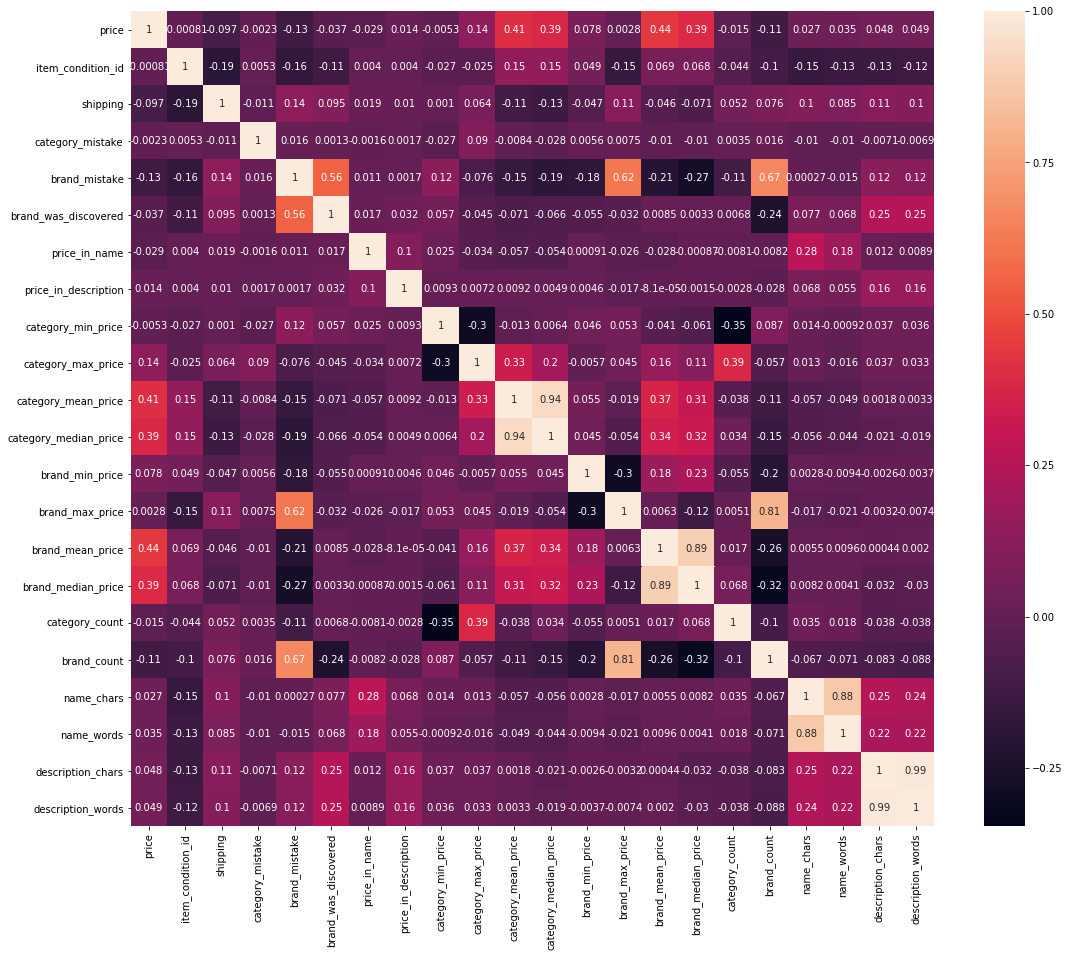

In [191]:
heatmap_data = df_train.filter(['price', 'item_condition_id', 'shipping', 'category_mistake', 'brand_mistake', 'brand_was_discovered', 'price_in_name', 'price_in_description', 'category_min_price', 'category_max_price', 'category_mean_price', 'category_median_price', 'brand_min_price', 'brand_max_price', 'brand_mean_price', 'brand_median_price', 'category_count', 'brand_count', 'name_chars',  'name_words', 'description_chars', 'description_words'])
corr = heatmap_data.corr()
plt.figure(figsize=(18, 15))
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

Few conclusions from heatmap:
* Price has very weak negative correlation with fact of missed brand name. I can understand it as relation of quality of product and quality of work of operator who forgot to enter brand name.
* No visible correlation of price with possibility of shipping.
* No correlation of price with declared item quality. Maybe it happens because product owners can't compare qualities of their product with quality of product of their competitors so it is impossible to set fair price.
* There are visible weak correlation between price and mean/median prices of brand and category. Reasons are pretty obvious.
* There is very weak negative correlation between price and number of products of specific brand (brand_count). I can understand it as people's wish to buy and use unique products.

In [192]:
def generate_features_from_name(df):
    df['name_bundle'] = np.where(df['name'].str.lower().str.contains('bundle'), 1, 0)
    df['name_onhold'] = np.where(df['name'].str.lower().str.contains('on hold'), 1, 0)
    df['name_reserved'] = np.where(df['name'].str.lower().str.contains('reserved'), 1, 0)
    
    return df

df_train = parallelize_dataframe(df_train, generate_features_from_name, cores)

In [193]:
def generate_features_from_description(df):
    df['description_brand_new'] = np.where(df['item_description'].str.lower().str.contains('brand new'), 1, 0)
    df['description_missing'] = np.where(df['item_description'].str.lower().str.contains('no description yet'), 1, 0)
    df['description_never_used'] = np.where(df['item_description'].str.lower().str.contains('never used') | df['item_description'].str.lower().str.contains('never worn'), 1, 0)
    df['description_incorrect_new'] = np.where(df['item_description'].str.lower().str.contains('nwt') | df['item_description'].str.lower().str.contains('nwot'), 1, 0)
    df['description_condition'] = np.where(df['item_description'].str.lower().str.contains('condition'), 1, 0)
    
    return df

df_train = parallelize_dataframe(df_train, generate_features_from_description, cores)

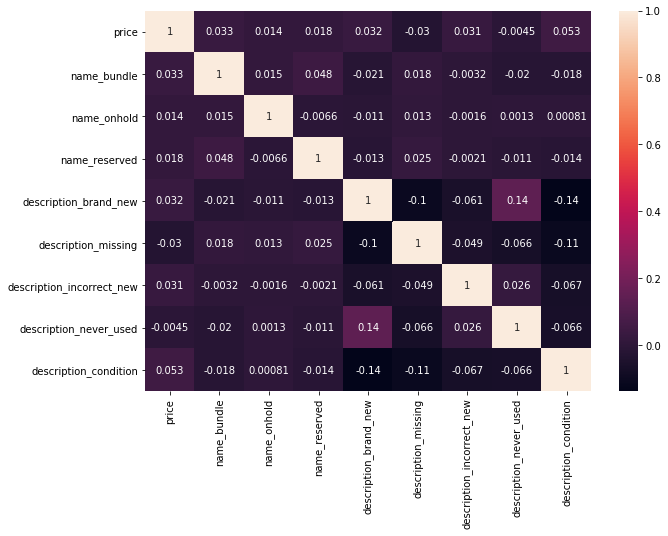

In [194]:
heatmap_data = df_train.filter(['price', 'name_bundle', 'name_onhold', 'name_reserved', 'description_brand_new', 'description_missing', 'description_incorrect_new', 'description_never_used', 'description_condition'])
corr = heatmap_data.corr()
plt.figure(figsize=(10, 7))
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

Few conclusions from heatmap:
* No visible correlation between price and words in item title or item description

In [195]:
df_train.drop(['name', 'category_name', 'brand_name', 'item_description', 'train_id'], axis=1, inplace=True)

In [196]:
df_train.head()

,item_condition_id,price,shipping,category_mistake,brand_mistake,brand_was_discovered,price_in_name,price_in_description,category_min_price,category_max_price,...,description_chars,description_words,name_bundle,name_onhold,name_reserved,description_brand_new,description_missing,description_never_used,description_incorrect_new,description_condition
0,3,10.0,1,0,1,1,1,1,0.0,309.0,...,18,3,0,0,0,0,1,0,0,0
1,3,52.0,0,0,0,0,1,1,3.0,750.0,...,188,36,0,0,0,0,0,0,0,1
2,1,10.0,1,0,0,0,0,1,0.0,329.0,...,124,29,0,0,0,0,0,0,0,0
3,1,35.0,1,0,1,0,1,1,0.0,848.0,...,173,32,0,0,0,0,0,0,0,0
4,1,44.0,0,0,1,0,1,1,0.0,1747.0,...,41,5,0,0,0,0,0,0,0,0


In [197]:
change_datatype_int(df_train)
change_datatype_float(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 30 columns):
item_condition_id            1482535 non-null int8
price                        1482535 non-null float32
shipping                     1482535 non-null int8
category_mistake             1482535 non-null int8
brand_mistake                1482535 non-null int8
brand_was_discovered         1482535 non-null int8
price_in_name                1482535 non-null int8
price_in_description         1482535 non-null int8
category_min_price           1482535 non-null float32
category_max_price           1482535 non-null float32
category_mean_price          1482535 non-null float32
category_median_price        1482535 non-null float32
brand_min_price              1482535 non-null float32
brand_max_price              1482535 non-null float32
brand_mean_price             1482535 non-null float32
brand_median_price           1482535 non-null float32
category_count               1482535 non-nul

Results:
* During this preprocessing we have made data transformation and normalizing that are required for further work.
* Basic feature generation was made from text and numerical data. Next step can be analyze of feature importances and creation of higher degree features
* Resulting data set contains 3.5 times more columns than initial data set and uses same amount of RAM.
* Despite quite big data set (1_500_000 examples) script demonstrates reasonable efficiency. Using remote server with 10 CPU cores it is executed during 4-5 minutes.